<a href="https://colab.research.google.com/github/YusufAbdurrahmans/plate-identification/blob/main/plate_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install ultralytics
!pip install -u ipywidgets
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
!gdown 18bfysgaE0MPQkA7VEpEa-73oqgvfXRlg

Downloading...
From (original): https://drive.google.com/uc?id=18bfysgaE0MPQkA7VEpEa-73oqgvfXRlg
From (redirected): https://drive.google.com/uc?id=18bfysgaE0MPQkA7VEpEa-73oqgvfXRlg&confirm=t&uuid=b9a1a295-8c38-43b3-8c63-f01451dbc2ba
To: /content/datasets.zip
100% 213M/213M [00:02<00:00, 106MB/s]


In [5]:
# Unzip dataset
!unzip datasets.zip

Archive:  datasets.zip
   creating: datasets/
   creating: datasets/lisence_plate/
   creating: datasets/lisence_plate/train/
   creating: datasets/lisence_plate/train/images/
  inflating: datasets/lisence_plate/train/images/Cars69.png  
  inflating: datasets/lisence_plate/train/images/Cars285.png  
  inflating: datasets/lisence_plate/train/images/Cars283.png  
  inflating: datasets/lisence_plate/train/images/Cars71.png  
  inflating: datasets/lisence_plate/train/images/Cars57.png  
  inflating: datasets/lisence_plate/train/images/Cars24.png  
  inflating: datasets/lisence_plate/train/images/Cars290.png  
  inflating: datasets/lisence_plate/train/images/Cars228.png  
  inflating: datasets/lisence_plate/train/images/Cars330.png  
  inflating: datasets/lisence_plate/train/images/Cars169.png  
  inflating: datasets/lisence_plate/train/images/Cars294.png  
  inflating: datasets/lisence_plate/train/images/Cars8.png  
  inflating: datasets/lisence_plate/train/images/Cars318.png  
  inflating

In [6]:
# import library
import os
import cv2
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from ultralytics import YOLO
import pytesseract
from pytesseract import Output

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


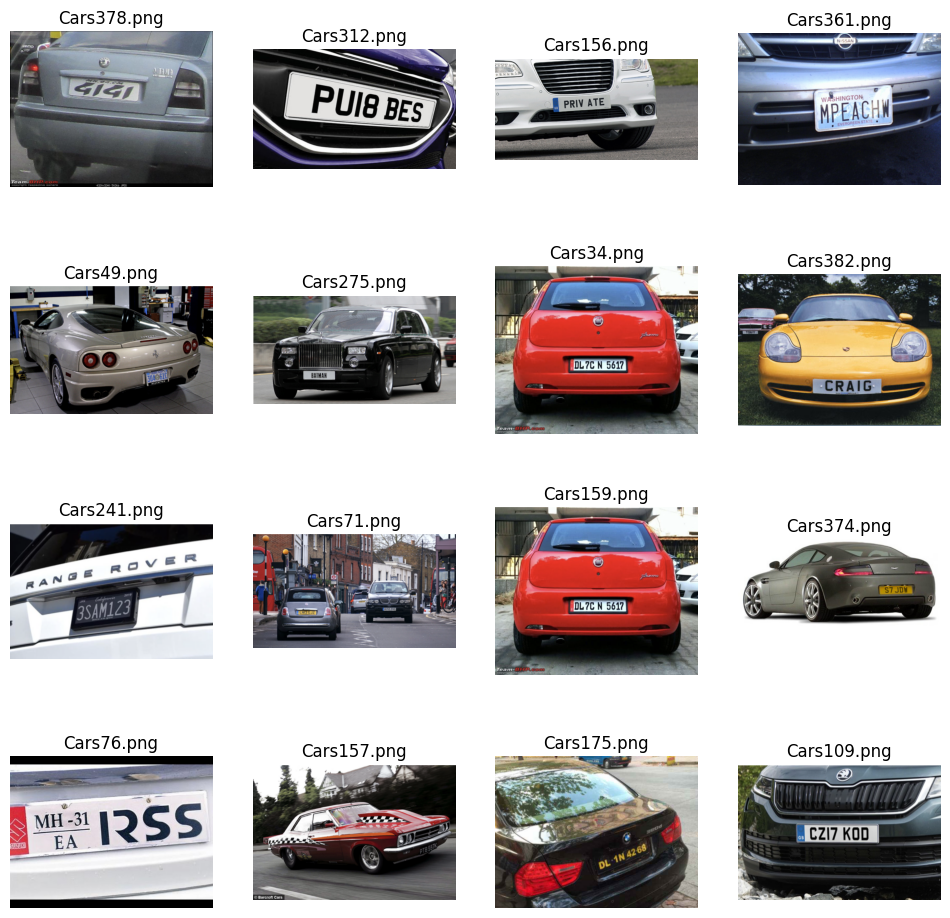

In [7]:
# menampilkan contoh data
train_images_dir = os.path.join("datasets","lisence_plate","train","images")
image_files = [f for f in os.listdir(train_images_dir) if f.endswith('png')]

image_files = image_files[:16]
rows, cols =4, 4

fig, axes = plt.subplots(rows, cols, figsize=(12,12))

for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(train_images_dir,image_files[i])
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(image_files[i])

plt.tight_layout
plt.show()

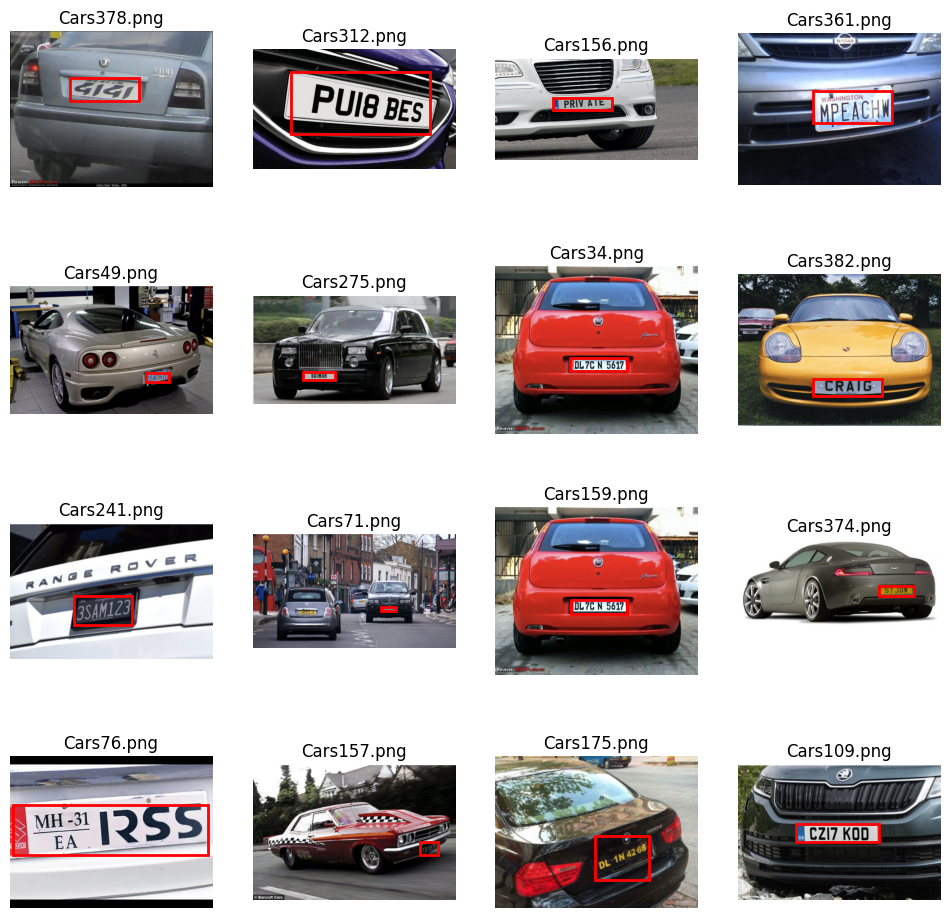

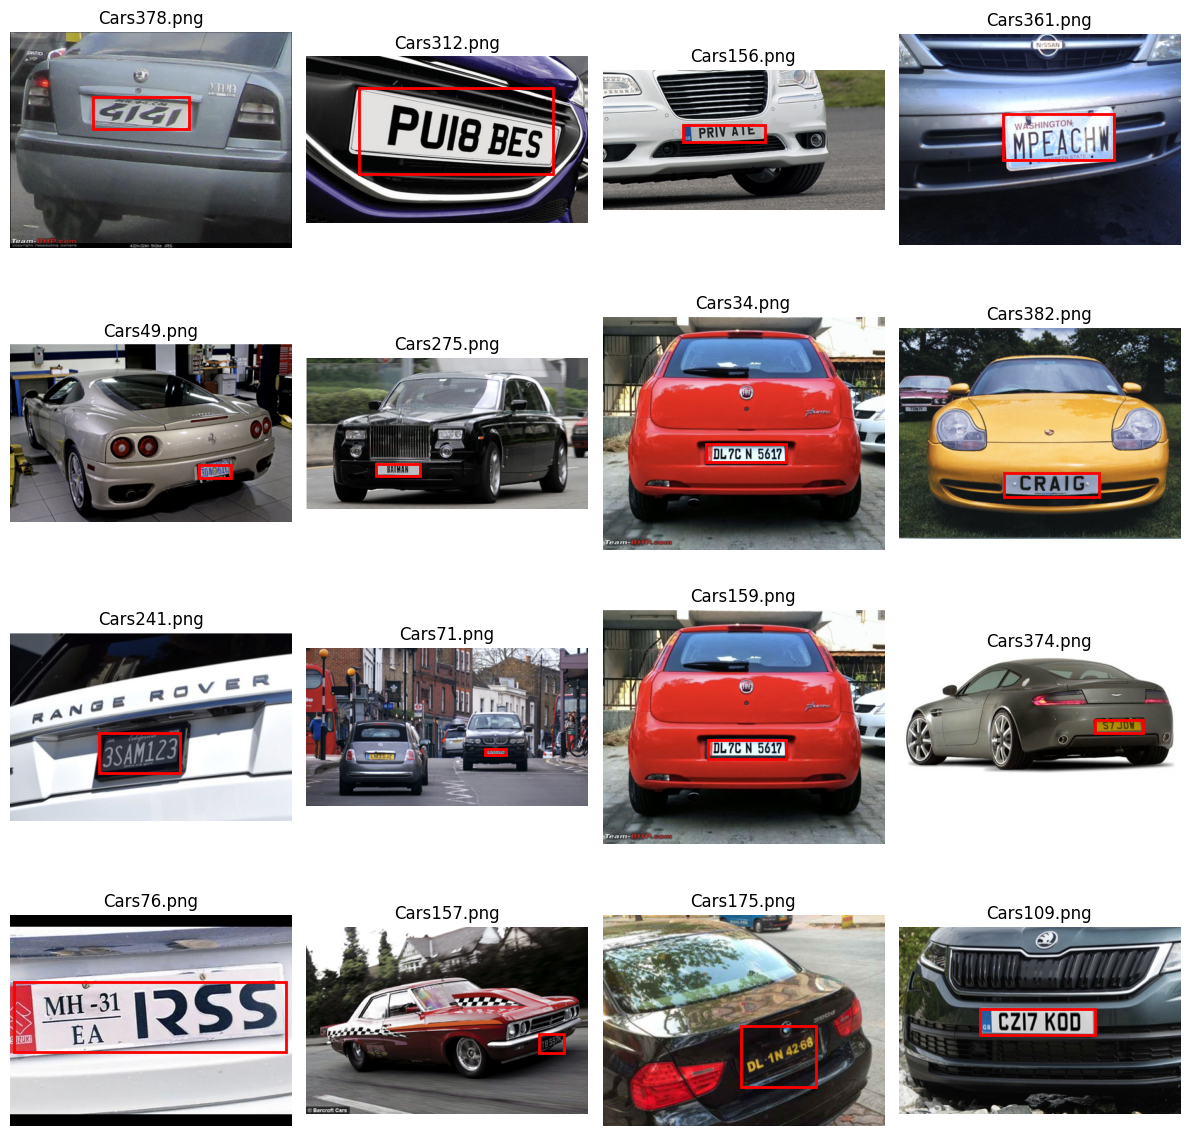

In [8]:
def read_bounding_boxes(path, width, height):
    boxes = []
    with open(path, "r") as f:
         lines = f.readlines()
         for line in lines:
             _, xc, yc, w, h = map(float, line.strip().split())
             xc *= width
             yc *= height
             w *= width
             h *= height
             x_min = xc - w/2
             y_min = yc - h/2
             boxes.append((x_min, y_min, w ,h))
    return boxes

train_images_dir = os.path.join("datasets", "lisence_plate","train","images")
train_labels_dir = os.path.join("datasets", "lisence_plate","train","labels")
image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
image_files = image_files[:16]
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):

    img_path = os.path.join(train_images_dir, image_files[i])
    img = Image.open(img_path)
    img_width, img_height = img.size
    label_path = os.path.join(train_labels_dir, os.path.splitext(image_files[i])[0] + '.txt')
    boxes = read_bounding_boxes(label_path, img_width, img_height)
    ax.imshow(img)

    for box in boxes:
        x_min, y_min, width, height = box
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

    ax.axis('off')
    ax.set_title(image_files[i])

def read_bounding_boxes(path, width, height):
    boxes = []
    with open(path, "r") as f:
         lines = f.readlines()
         for line in lines:
             _, xc, yc, w, h = map(float, line.strip().split())
             xc *= width
             yc *= height
             w *= width
             h *= height
             x_min = xc - w/2
             y_min = yc - h/2
             boxes.append((x_min, y_min, w ,h))
    return boxes

import os
from PIL import Image
import matplotlib.pyplot as plt

train_images_dir = os.path.join("datasets", "lisence_plate","train","images")
train_labels_dir = os.path.join("datasets", "lisence_plate","train","labels")

image_files = [f for f in os.listdir(train_images_dir) if f.endswith(('jpg', 'jpeg', 'png'))]
image_files = image_files[:16]

rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(train_images_dir, image_files[i])
    img = Image.open(img_path)
    img_width, img_height = img.size

    label_path = os.path.join(train_labels_dir, os.path.splitext(image_files[i])[0] + '.txt')
    boxes = read_bounding_boxes(label_path, img_width, img_height)

    ax.imshow(img)

    for box in boxes:
        x_min, y_min, width, height = box
        rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(rect)

    ax.axis('off')
    ax.set_title(image_files[i])

plt.tight_layout()
plt.show()